Title (Steve, Eva, Liam, Jacky)

Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and describe the dataset that was used to answer the question

Methods & Results:

describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend

#### 1. loading in all the packages for data analysis

In [1]:
install.packages("themis")
install.packages("kknn")
library(kknn)
library(purrr)
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### 2. Reading in the data from the web, and Preparation of Data analysis

The dataset “User Knowledge Modeling” is the online dataset download from Archive.
Our goal is to predict UNS (The knowledge level of user) by utilizing K-NN classification. The
UNS is a categorical data distinct by 4 level: “High,” “Middle,” “Low,” and “Very Low.”

The first thing we do after loading the data is factorize the variable named UNS by using the
function as.factor. Then, we have grouped the factor levels for future usage. Then, we
realized that the last row restores NA-values across all the variables, so we just simply
deleted the last row of the dataset


In [3]:
set.seed(1234) 
options(repr.plot.height = 5, repr.plot.width = 6)

##Loading data
url <- "https://github.com/JackyLinllk/ubc_dsci100_assignment/raw/main/data/Data_User_Modeling_Dataset_full.csv"
knowledge_data<-read_csv(url)|>
    select(STG:UNS)|>
    mutate(UNS = as.factor(UNS))

##Check NA rows
na_row= which(!complete.cases(knowledge_data))
print(na_row)

##Delete the NA row of the data
knowledge_data= knowledge_data[-nrow(knowledge_data),]


New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
Rows: 404 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG
lgl (3): ...7, ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


we check the data’s tidiness by looking into 3 factors, which are: (1) each row is
a single observation, (2) Each column is a single variable, (3) Each value is in single cell. In
this case, we realize that under the quantitative variable named UNS, the factor levels
named “very_low” and “Very Low” should be in the same level. Thus, we apply the function
mutate with function fct_recode to merge two factor levels into one

In [ ]:
##Typo in the dataset #very_low and Very Low should be same observation
knowledge_data= knowledge_data|>
  mutate(UNS = fct_recode(UNS, "very_low"="Very Low"))
  

## Check proportion and visualizing
class_prop = knowledge_data|>
  group_by(UNS)|>
  summarize(count = n(),
            percentage= count/nrow(knowledge_data)
  )
class_prop

##Balancing the data
ups_recipe= recipe(UNS~. ,data=knowledge_data)|>
  step_upsample(UNS, over_ratio=1, skip=F)|>
  prep()
upsampled_knowledge=bake(ups_recipe, knowledge_data)

##Checking the balance
upsampled_knowledge|>
  group_by(UNS)|>
  summarize(n=n())

upsampled_knowledge

#### 3. Spliting the data into 70% properation of training data and testing data

We separated the data using the initial_split function to create 2 subsets, namely training set and testing set.
Inside the initial_split function, we set strata argument to the categorical variable UNS. The
training and testing functions are used to create two different data frames with the
corresponding weight of 70% and 30%.

In [4]:

##Split the data into training set and testing set
knowledge_data_split <- initial_split(upsampled_knowledge, prop = 0.70, strata = UNS)  
knowledge_data_split_train <- training(knowledge_data_split)
knowledge_data_split_test <- testing(knowledge_data_split)

knowledge_data_split_train

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.50,0.20,0.85,High
0.18,0.18,0.55,0.30,0.81,High
0.05,0.07,0.70,0.01,0.05,very_low
⋮,⋮,⋮,⋮,⋮,⋮
0.68,0.43,0.60,0.47,0.55,Middle
0.66,0.68,0.81,0.57,0.57,Middle
NA,NA,NA,NA,NA,NA


 #### 4. Parameter selection: Finding the best K value
 Our next step is to find the best K value which maximizes the accuracy for our model,
where K is the number of neighbors. We will be using cross-validation with validation set of
5 in the training set to find the best possible k value. In other words, we will split our
training data into 5 training sets. 

Firstly, we apply nearest_neighbor, set_engine, and set_mode
functions to create a model specification. Inside the nearest_neighbor function, the argument
weight_func is set to rectangular, which means each k neighbor are equally important. For
the neighbors argument, tune() is telling the framework to find the different parameter values
for K.

Since KNN classification uses Euclidean distance between points, so it is very sensitive
to the different types of scale. Thus, we planned to standardize the variables for all chosen
variables to ensure the predictive algorithms are accurate and unbiased. We managed to
standardize all the variables by using the recipe function with step_center(all_predictors()) and
step_scale(all_predictors()).

Back to cross-validation, we use vfold_cv function to set the validation set into 5 folds
by using the training set. Finally, we create a tribble with neighbors and use the seq function to
set the K-values to odd numbers (e.g., 1,3,5... 𝑛). The reason why we don’t want even
numbers is because each neighbor is equally weighted; therefore, the even numbers will
cause confusion.

Finally, we put everything into workflow to chain all the steps together to get the
accuracy of different K-values. 


In [5]:

##Finding the k value for best accuracy
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

##Choosing all the variables as predictors, and standardize it
data_recipe <- recipe(UNS ~. , data = knowledge_data_split_train)|>
  step_center(all_predictors())|>
  step_scale(all_predictors())

training_vfold <-  vfold_cv(knowledge_data_split_train, v=5, strata = UNS)

k_value = 101
K <- tibble(neighbors = seq(1,k_value,2))

knn_result <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_tune)|>
  tune_grid(resamples = training_vfold, grid = K) |>
  collect_metrics()|>
  filter(.metric == "accuracy")


x Fold5: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ℹ In argument: `.row = orig_rows`.
  Caused by error:
  ! `.row` must be size 55 or 1, not 56.



#### 5. Visualizing the optimal K-value

We used the ggplot function to create a line graph which
helps to visualize the accuracy trends under corresponding K-values. Surprisingly, when the
K=1, we have the most accurate K-value for the model. Thus, we choose K equals to one as
our optimal K-value.

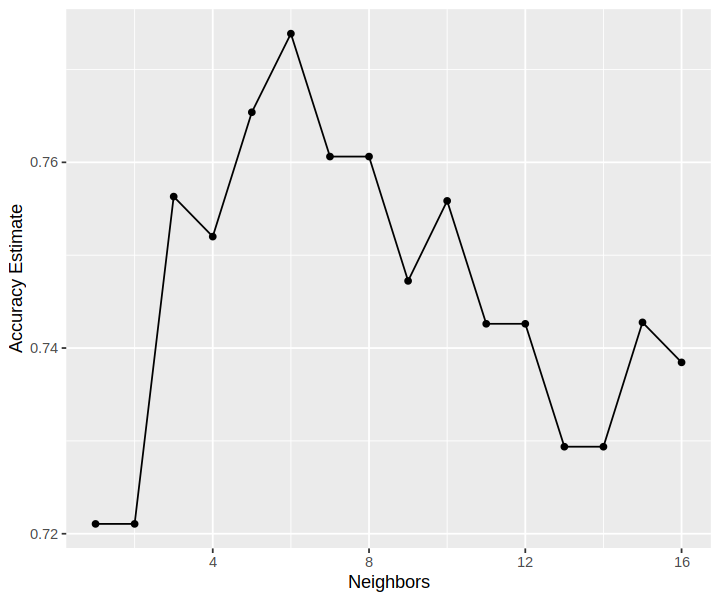

In [6]:
##Scatter plot on the accuracy and number of neighbors
cross_val_plot <- ggplot(knn_result, aes(x=neighbors, y= mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle(label= "KNN Accuracy verses Number of Neighbors")
cross_val_plot

#### 6. Creating the model with the optimal K-value

In [7]:

##Finding confusion matrix of model using testing set
knn_best_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")


knn_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_best_tune)|>
  fit(knowledge_data_split_train)



#### 7. Predicting the model on the testing data set

In [8]:
knowledge_predictions= knn_fit|>
  predict(knowledge_data_split_test)|>
  bind_cols(knowledge_data_split_test)

knowledge_metrics= knowledge_predictions|>
  metrics(truth= UNS, estimate = .pred_class)|>
  filter(.metric== "accuracy")

knowledge_conf_mat= knowledge_predictions|>
  conf_mat(truth= UNS, estimate = .pred_class)

knowledge_conf_mat

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Very Low,0.00,0.00,0.00,0.00,0.0,very_low
Middle,0.08,0.08,0.10,0.24,0.9,High
Middle,0.10,0.10,0.15,0.65,0.3,Middle
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Low,0.58,0.40,0.32,0.22,0.24,Low
High,0.85,0.82,0.66,0.83,0.83,High
Middle,0.68,0.64,0.79,0.97,0.24,Middle


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `UNS = fct_recode(...)`.
Caused by warning:
! Unknown levels in `f`: Very_low”


UNS,count
<fct>,<int>
High_pred,30
Low_pred,56
Middle_pred,32
⋮,⋮
Middle,39
Very Low,8
very_low,8


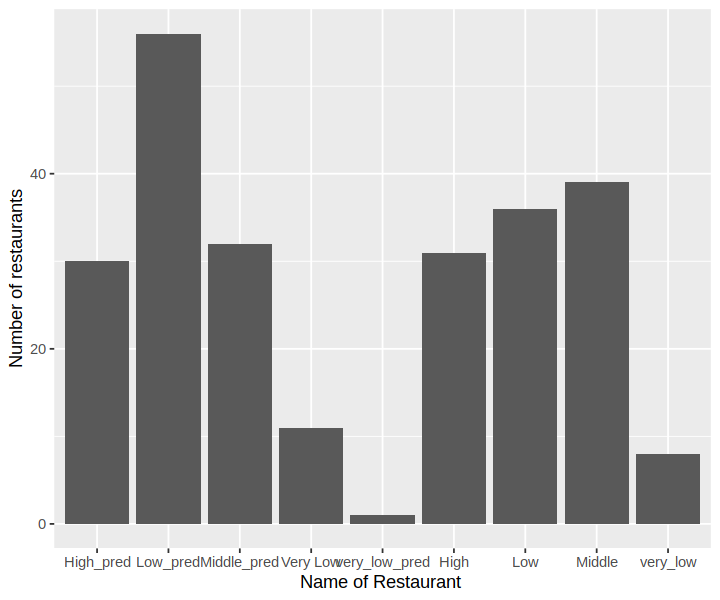

In [9]:
count <- test_prediction|>
    group_by(.pred_class) |>
    summarize(count = n())|>
    rename(UNS = .pred_class)|>
    mutate(UNS = fct_recode(UNS, High_pred = "High", Low_pred = "Low", Middle_pred = "Middle", Very_low_pred = "Very_low", very_low_pred = "very_low"))

count2 <- test_prediction|>
    group_by(UNS) |>
    summarize(count = n())

count3 <- rbind(count, count2)
count3

graph_dis <- ggplot(count3, aes(x= UNS, y= count))+
    geom_bar(stat = "identity") +
    xlab("Name of Restaurant ") +
    ylab("Number of restaurants")
graph_dis

#### 8. Evaluating the model

After we have our confusion matrix, we are planning to calculate the corresponding
accuracy, precision, and recall for all the diagonal entries (where 𝑖 = 𝑗). Since the confusion
matrix is in the list, we first convert it into matrix form.
For the accuracy calculation, we apply the formula: 𝐴𝑐𝑐𝑢𝑟𝑎𝑐𝑦 = 𝑁𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛
𝑇𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠 ,
where the number of correct predictions are the diagonal entries, and the total number of
predictions are the sum of all entries. In R, we can simply calculate the accuracy by:
sum(diag(matrix))/sum(matrix)
For precision calculation, the formula is: 𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 = 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠
𝑡𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠 ,
where the number of correct positive predictions corresponds to the specific diagonal value,
and the total number of positive predictions are the sum of rows in that diagonal value.
Thus, we will be calculating all the diagonal entries one by one. For example,
𝐶𝑚,𝑚 = 𝑚𝑎𝑡𝑟𝑖𝑥[𝑚,𝑚]/(𝑠𝑢𝑚(𝑚𝑎𝑡𝑟𝑖𝑥[𝑚,]))
Then we take the average of all diagonal entries to find the average precision for our model.
For recall calculation, the formula is: 𝑅𝑒𝑐𝑎𝑙𝑙 = 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠
𝑇𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒 𝑡𝑒𝑠𝑡 𝑠𝑒𝑡 𝑜𝑏𝑠𝑒𝑟𝑣𝑎𝑡𝑖𝑜𝑛𝑠, where
the number of correct positive predictions are the specific diagonal value, and the total
number of positive test set observations are the sum of the column in that diagonal value.
For example,
𝐶𝑚,𝑚 = 𝑚𝑎𝑡𝑟𝑖𝑥[𝑚,𝑚]/(𝑠𝑢𝑚(𝑚𝑎𝑡𝑟𝑖𝑥[,𝑚]))
Similarly, we will take the average of all diagonal entries to find the average recall for our
model.


In [10]:
mnist_metrics  <- test_prediction |>
    metrics(truth = UNS, estimate = .pred_class)
mnist_metrics

mnist_conf_mat <- test_prediction|>
    conf_mat(truth = UNS, estimate = .pred_class)

mnist_conf_mat

##Calculating the Accuracy/Precision/Recall
knowledge_matrix= matrix(unlist(knowledge_conf_mat), nrow = 4) ##Convert list into 5x5 matrix

knowledge_accuracy= sum(diag(knowledge_matrix))/sum(knowledge_matrix) #Accuracy

knowledge_precision_high= knowledge_matrix[1,1]/(sum(knowledge_matrix[,1]))#precision for high
knowledge_precision_low= knowledge_matrix[2,2]/(sum(knowledge_matrix[,2]))#precision for low
knowledge_precision_middle= knowledge_matrix[3,3]/(sum(knowledge_matrix[,3]))#precision for middle
knowledge_precision_very_low= knowledge_matrix[4,4]/(sum(knowledge_matrix[,4]))#precision for very low
average_precision= mean(knowledge_precision_high,
                        knowledge_precision_low, 
                        knowledge_precision_middle,
                        nowledge_precision_very_low)


knowledge_recall_high= knowledge_matrix[1,1]/(sum(knowledge_matrix[1,]))#Recall for high
knowledge_recall_low= knowledge_matrix[2,2]/(sum(knowledge_matrix[2,]))#Recall for low
knowledge_recall_middle= knowledge_matrix[3,3]/(sum(knowledge_matrix[3,]))#Recall for middle
knowledge_recall_very_low= knowledge_matrix[4,4]/(sum(knowledge_matrix[4,]))#Recall for very low
average_recall= mean(knowledge_recall_high,
                        knowledge_recall_low, 
                        knowledge_recall_middle,
                        nowledge_recall_very_low)


summary_prediction= data.frame(
   accuracy= knowledge_accuracy,
   precision= average_precision, 
   average_recall)

summary_prediction

knowledge_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7377049
kap,multiclass,0.6337024


          Truth
Prediction High Low Middle Very Low very_low
  High       26   0      4        0        0
  Low         0  36      8        8        4
  Middle      5   0     27        0        0
  Very Low    0   0      0        0        3
  very_low    0   0      0        0        1

Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

In [11]:
##loading package
install.packages("themis")
library(kknn)
library(purrr)
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)

options(repr.matrix.max.rows = 6)


also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [12]:
set.seed(1234) 
options(repr.plot.height = 5, repr.plot.width = 6)

##Loading data
url <- "https://github.com/JackyLinllk/ubc_dsci100_assignment/raw/main/data/Data_User_Modeling_Dataset_full.csv"
knowledge_data<-read_csv(url)|>
  select(STG:UNS)|>
  mutate(UNS = as.factor(UNS))

##Check NA rows
na_row= which(!complete.cases(knowledge_data))
print(na_row)

##Delete the NA row of the data
knowledge_data= knowledge_data[-nrow(knowledge_data),]

##Typo in the dataset #very_low and Very Low should be same observation
knowledge_data= knowledge_data|>
  mutate(UNS = fct_recode(UNS, "very_low"="Very Low"))
  

## Check proportion and visualizing
class_prop = knowledge_data|>
  group_by(UNS)|>
  summarize(count = n(),
            percentage= count/nrow(knowledge_data)
  )
class_prop

##Balancing the data
ups_recipe= recipe(UNS~. ,data=knowledge_data)|>
  step_upsample(UNS, over_ratio=1, skip=F)|>
  prep()
upsampled_knowledge=bake(ups_recipe, knowledge_data)

##Checking the balance
upsampled_knowledge|>
  group_by(UNS)|>
  summarize(n=n())

upsampled_knowledge

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
Rows: 404 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG
lgl (3): ...7, ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 404


UNS,count,percentage
<fct>,<int>,<dbl>
High,102,0.2531017
Low,129,0.3200993
Middle,122,0.3027295
very_low,50,0.1240695


UNS,n
<fct>,<int>
High,129
Low,129
Middle,129
very_low,129


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.299,0.70,0.95,0.22,0.66,High
0.320,0.28,0.72,0.89,0.58,High
0.300,0.16,0.89,0.32,0.95,High
⋮,⋮,⋮,⋮,⋮,⋮
0.000,0.62,0.52,0.26,0.07,very_low
0.520,0.28,0.32,0.10,0.10,very_low
0.248,0.30,0.31,0.20,0.03,very_low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.299,0.70,0.95,0.22,0.66,High
0.320,0.28,0.72,0.89,0.58,High
0.300,0.16,0.89,0.32,0.95,High
⋮,⋮,⋮,⋮,⋮,⋮
0.000,0.62,0.52,0.26,0.07,very_low
0.520,0.28,0.32,0.10,0.10,very_low
0.248,0.30,0.31,0.20,0.03,very_low


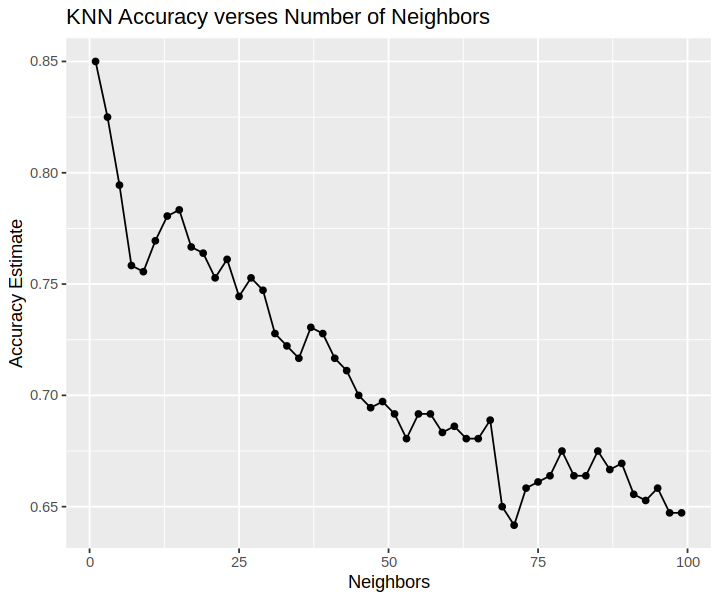

In [16]:
##Split the data into training set and testing set
knowledge_data_split <- initial_split(upsampled_knowledge, prop = 0.70, strata = UNS)  
knowledge_data_split_train <- training(knowledge_data_split)
knowledge_data_split_test <- testing(knowledge_data_split)

knowledge_data_split_train


##Finding the k value for best accuracy
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

data_recipe <- recipe(UNS ~. , data = knowledge_data_split_train)|>
  step_center(all_predictors())|>
  step_scale(all_predictors())

training_vfold <-  vfold_cv(knowledge_data_split_train, v=5, strata = UNS)

#k_value= sqrt(nrow(knowledge_data_split_train))
k_value = 100
K <- tibble(neighbors = seq(1,k_value,2))

knn_result <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_tune)|>
  tune_grid(resamples = training_vfold, grid = K) |>
  collect_metrics()|>
  filter(.metric == "accuracy")

##Scatter plot on the accuracy and number of neighbors
cross_val_plot <- ggplot(knn_result, aes(x=neighbors, y= mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle(label= "KNN Accuracy verses Number of Neighbors")
cross_val_plot


##Finding confusion matrix of model using testing set
knn_best_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")

In [14]:

knn_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_best_tune)|>
  fit(knowledge_data_split_train)


knowledge_predictions= knn_fit|>
  predict(knowledge_data_split_test)|>
  bind_cols(knowledge_data_split_test)

knowledge_metrics= knowledge_predictions|>
  metrics(truth= UNS, estimate = .pred_class)|>
  filter(.metric== "accuracy")

knowledge_conf_mat= knowledge_predictions|>
  conf_mat(truth= UNS, estimate = .pred_class)

knowledge_conf_mat

##Calculating the Accuracy/Precision/Recall
knowledge_matrix= matrix(unlist(knowledge_conf_mat), nrow = 4) ##Convert list into 5x5 matrix

knowledge_accuracy= sum(diag(knowledge_matrix))/sum(knowledge_matrix) #Accuracy

knowledge_precision_high= knowledge_matrix[1,1]/(sum(knowledge_matrix[,1]))#precision for high
knowledge_precision_low= knowledge_matrix[2,2]/(sum(knowledge_matrix[,2]))#precision for low
knowledge_precision_middle= knowledge_matrix[3,3]/(sum(knowledge_matrix[,3]))#precision for middle
knowledge_precision_very_low= knowledge_matrix[4,4]/(sum(knowledge_matrix[,4]))#precision for very low
average_precision= mean(knowledge_precision_high,
                        knowledge_precision_low, 
                        knowledge_precision_middle,
                        nowledge_precision_very_low)


knowledge_recall_high= knowledge_matrix[1,1]/(sum(knowledge_matrix[1,]))#Recall for high
knowledge_recall_low= knowledge_matrix[2,2]/(sum(knowledge_matrix[2,]))#Recall for low
knowledge_recall_middle= knowledge_matrix[3,3]/(sum(knowledge_matrix[3,]))#Recall for middle
knowledge_recall_very_low= knowledge_matrix[4,4]/(sum(knowledge_matrix[4,]))#Recall for very low
average_recall= mean(knowledge_recall_high,
                        knowledge_recall_low, 
                        knowledge_recall_middle,
                        nowledge_recall_very_low)


summary_prediction= data.frame(
   accuracy= knowledge_accuracy,
   precision= average_precision, 
   average_recall)

summary_prediction

knowledge_metrics


          Truth
Prediction High Low Middle very_low
  High       38   0      1        0
  Low         0  31      0        1
  Middle      1   4     38        0
  very_low    0   4      0       38

accuracy,precision,average_recall
<dbl>,<dbl>,<dbl>
0.9294872,0.974359,0.974359


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9294872
